# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  

The business objective is to determine the factors that influence the price of used cars. Car delaer would like to know what are the feature of the cars which influence its price, which type of cars sells more, is there a way for them to use data and predict the price at which a car may sell? This will help the car dealers with buying and stocking decisions, moving the inventory to right regions, run promotions to clear inventory and make purchases data driven instead of indivdual experience based decisions.  

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
# Read in the vehicles dataset into a dataframe. car_sales dataframe will be used throughout the project for analysis and model development

car_sales = pd.read_csv('data/vehicles.csv')

In [5]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

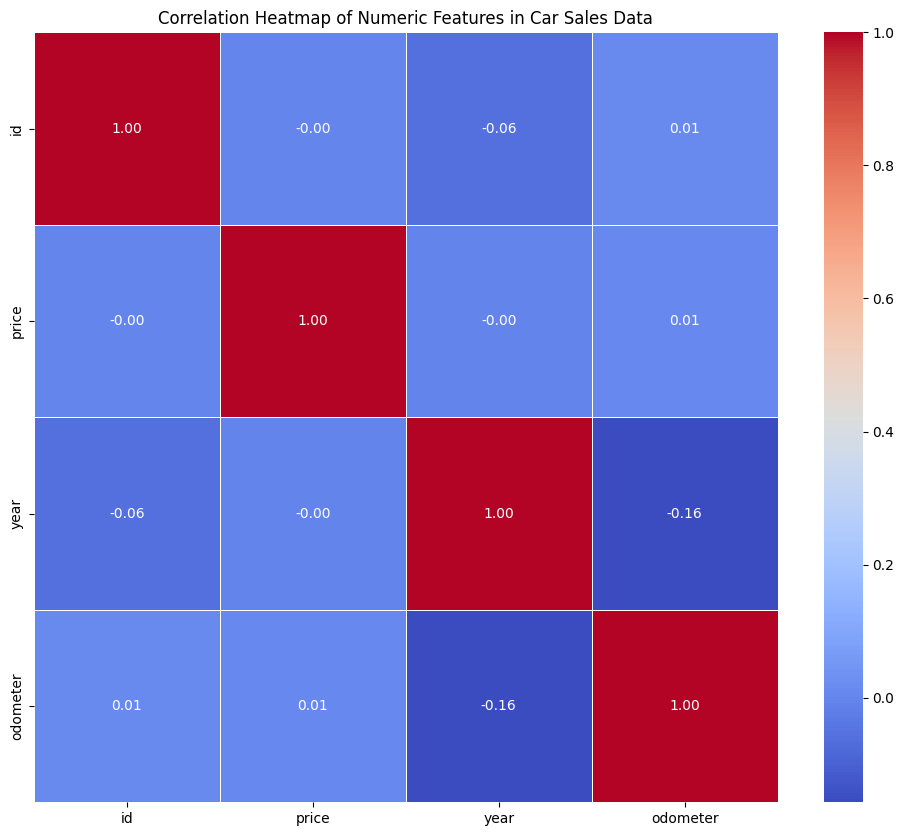

In [6]:
# A correlation heatmap between numeric features of car_sales

# Select only numeric columns for the correlation matrix
numeric_car_sales = car_sales.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_car_sales.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features in Car Sales Data')
plt.show()


There is no correlation visible between the numeric features. We will repeat this after data cleaning.

In [7]:
# Remove some of the features as they have no impact on car prices
car_sales.drop(['id','VIN','paint_color'], axis=1, inplace=True)

Investigate the dataset for missing or problematic data.

In [8]:
# Check for missing values
print(car_sales.isnull().sum().sort_values())

region               0
price                0
state                0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
drive           130567
condition       174104
cylinders       177678
size            306361
dtype: int64


Some features like size and cyliders have too many NaN values, deleting them will wipe out most of our dataset. We will assign not_given value to them and will have to exclude such features from analysis

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

Drop irrelevant columns

In [10]:
# Replace NaN values in  some columns with "not_given"

car_sales['type'] = car_sales['type'].fillna('not_given')
car_sales['size'] = car_sales['size'].fillna('not_given')
car_sales['manufacturer'] = car_sales['manufacturer'].fillna('not_given')
car_sales['condition'] = car_sales['condition'].fillna('not_given')
car_sales['cylinders'] = car_sales['cylinders'].fillna('not_given')
car_sales['drive'] = car_sales['drive'].fillna('not_given')
car_sales['model'] = car_sales['model'].fillna('not_given')

In [11]:
# How many rows do I have in car_sales

print(len(car_sales))

426880


In [12]:
# Drop rows with NaN values for the remaining features

print(car_sales.isnull().sum().sort_values())
car_sales.dropna(inplace=True)
print(car_sales.isnull().sum().sort_values())

region             0
price              0
manufacturer       0
model              0
cylinders          0
condition          0
state              0
drive              0
type               0
size               0
year            1205
transmission    2556
fuel            3013
odometer        4400
title_status    8242
dtype: int64
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
state           0
dtype: int64


In [10]:
# Remaining data in car_sales

print(len(car_sales))

410742


In [13]:
# Sort the DataFrame by 'price' in descending order and select the top 20
car_sales.sort_values(by='price', ascending=False).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
318592,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,4wd,full-size,pickup,or
356716,knoxville,3736928711,1999.0,toyota,4runner,fair,6 cylinders,gas,211000.0,clean,automatic,4wd,mid-size,not_given,tn
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,de
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nj
37410,modesto,3009548743,2021.0,chevrolet,not_given,not_given,8 cylinders,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
184704,frederick,1410065407,1989.0,jeep,wrangler,not_given,not_given,diesel,103000.0,clean,manual,not_given,not_given,SUV,md
153082,indianapolis,1234567890,2006.0,volvo,vnl,fair,not_given,other,200000.0,clean,manual,not_given,not_given,not_given,in
29386,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0,clean,automatic,rwd,full-size,pickup,ca
37409,modesto,1111111111,2020.0,jeep,not_given,not_given,not_given,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
122470,atlanta,987654321,1960.0,chevrolet,not_given,not_given,not_given,gas,9999999.0,clean,manual,not_given,not_given,not_given,ga


There are many unrealistic items like car price "123456789" which is clearly made up

In [14]:
# Drop rows inplace with price value which are exceptionally high like $300+ million or made up like "1234567890".

prices_to_drop = [135008900, 25003000, 17000000, 2000000, 99999999, 3226714, 987654321, 12345678, 123456789, 3736928711, 1234567, 1234567890, 1111111111, 1111111]

# Drop rows where 'price' is in the list of prices to drop
car_sales.drop(car_sales[car_sales['price'].isin(prices_to_drop)].index, inplace=True)

In [15]:
# Sort the DataFrame by 'price' in descending order and select the top 20
car_sales.sort_values(by='price', ascending=False).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,de
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nj
37410,modesto,3009548743,2021.0,chevrolet,not_given,not_given,8 cylinders,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
184704,frederick,1410065407,1989.0,jeep,wrangler,not_given,not_given,diesel,103000.0,clean,manual,not_given,not_given,SUV,md
241404,raleigh / durham / CH,113456789,1980.0,bmw,not_given,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nc
353641,jackson,11111111,1966.0,chevrolet,c10,not_given,not_given,gas,111111.0,clean,automatic,not_given,not_given,not_given,tn
300308,mansfield,10004000,2002.0,ford,f350,not_given,not_given,other,215000.0,clean,other,not_given,not_given,not_given,oh
105843,orlando,6995495,2014.0,dodge,journey,not_given,4 cylinders,gas,135888.0,clean,automatic,fwd,not_given,SUV,fl
283906,new hampshire,5000000,2021.0,not_given,all,not_given,not_given,other,1.0,clean,other,not_given,not_given,not_given,nh
286156,north dakota,1666666,1902.0,not_given,Recycling,not_given,not_given,other,1111111.0,parts only,other,not_given,not_given,not_given,nd


There are still many unrealistic values for price

In [16]:
# Create a separate dataframe car_sales_premium and move all cars more expensive than 100000 to car_sales_premium. Drop those cars more expensive than 120000 from car-sales dataframe inplace. Print the count of both car types

car_sales_premium = car_sales[car_sales['price'] > 100000].copy()
car_sales.drop(car_sales[car_sales['price'] > 100000].index, inplace=True)

print(f"Count of regular cars: {len(car_sales)}")
print(f"Count of premium cars: {len(car_sales_premium)}")

Count of regular cars: 410104
Count of premium cars: 595


Cars with extremely high prices can be dealt with separately (weather they are actually expensive or have made up prices like 1111111)

In [17]:
# Sort the DataFrame by 'price' in ascending order and select the top 20
car_sales.sort_values(by='price', ascending=True).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
333065,philadelphia,0,2015.0,dodge,charger,not_given,not_given,gas,95807.0,clean,automatic,not_given,full-size,sedan,pa
333026,philadelphia,0,2010.0,jeep,grand cherokee,not_given,not_given,other,175675.0,clean,automatic,not_given,not_given,not_given,pa
333031,philadelphia,0,2016.0,ford,f450 4x4,not_given,not_given,diesel,0.0,clean,other,not_given,not_given,other,pa
333036,philadelphia,0,2013.0,mercedes-benz,gl-class,not_given,not_given,gas,79649.0,clean,automatic,not_given,not_given,SUV,pa
333037,philadelphia,0,2014.0,chevrolet,express,not_given,not_given,other,121300.0,clean,automatic,4wd,not_given,van,pa
333039,philadelphia,0,2013.0,mercedes-benz,gl-class,not_given,not_given,gas,79649.0,clean,automatic,not_given,not_given,SUV,pa
333021,philadelphia,0,2013.0,infiniti,jx35,not_given,not_given,gas,104329.0,clean,automatic,not_given,not_given,SUV,pa
157418,des moines,0,2013.0,nissan,sentra,excellent,4 cylinders,gas,86373.0,clean,automatic,fwd,sub-compact,sedan,ia
157419,des moines,0,2011.0,not_given,Scion xB,excellent,4 cylinders,gas,159810.0,clean,automatic,fwd,not_given,wagon,ia
157420,des moines,0,2017.0,gmc,savana commercial cutaway,excellent,8 cylinders,gas,200706.0,clean,automatic,rwd,not_given,not_given,ia


Several cars which has 0 or really low prices, not useful for our analysis and could be outliers

In [18]:
# Count of cars with less than $2000 price and drop those rows, as the car dealers may not be interested in such cars

# Count of cars with price less than 2000
num_cars_low_price = car_sales[car_sales['price'] < 2000].shape[0]
print(f"Number of cars with price less than $2000: {num_cars_low_price}")

# Drop rows where the price is less than 2000
car_sales.drop(car_sales[car_sales['price'] < 2000].index, inplace=True)

# Verify the rows with price less than 2000 have been dropped
num_cars_low_price_after_drop = car_sales[car_sales['price'] < 2000].shape[0]
print(f"Number of cars with price less than $2000 after dropping: {num_cars_low_price_after_drop}")

Number of cars with price less than $2000: 49020
Number of cars with price less than $2000 after dropping: 0


In [19]:
# Sort the DataFrame by 'price' in ascending order and select the top 20
car_sales.sort_values(by='price', ascending=True).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
28837,gold country,2000,1995.0,not_given,1995 Saab 9000,good,4 cylinders,gas,122063.0,salvage,manual,fwd,full-size,hatchback,ca
156783,des moines,2000,2002.0,nissan,frontier crew cab se 4x4,good,6 cylinders,gas,200000.0,clean,automatic,4wd,mid-size,truck,ia
351078,sioux falls / SE SD,2000,2008.0,volkswagen,touareg,like new,6 cylinders,gas,143000.0,clean,automatic,4wd,mid-size,SUV,sd
203942,jackson,2000,2005.0,chevrolet,impala ls,fair,6 cylinders,gas,213596.0,clean,automatic,fwd,mid-size,sedan,mi
319295,medford-ashland,2000,2008.0,hyundai,accent,fair,4 cylinders,gas,157244.0,clean,manual,fwd,compact,sedan,or
92999,daytona beach,2000,1990.0,ford,bronco,fair,8 cylinders,gas,1.0,clean,automatic,4wd,not_given,not_given,fl
60737,SF bay area,2000,2007.0,ford,focus,excellent,4 cylinders,gas,221973.0,clean,manual,fwd,not_given,sedan,ca
247402,las vegas,2000,1999.0,pontiac,montana van,good,6 cylinders,gas,141000.0,clean,automatic,fwd,full-size,van,nv
157408,des moines,2000,2004.0,chevrolet,impala,good,not_given,gas,223509.0,clean,automatic,not_given,not_given,not_given,ia
378627,mcallen / edinburg,2000,2013.0,buick,enclave,not_given,not_given,gas,162234.0,clean,automatic,not_given,not_given,not_given,tx


In [17]:
# Sort based on odometer value descending order
# Find the number of cars with more than 300000 odometer value and delete those rows.
# Car delars may not be interested in cars with such high reading

# Count the number of cars with odometer value more than 300000
num_cars_high_odometer = car_sales[car_sales['odometer'] > 300000].shape[0]
print(f"Number of cars with odometer value more than 300000: {num_cars_high_odometer}")

# Drop rows where the odometer value is more than 300000
car_sales.drop(car_sales[car_sales['odometer'] > 300000].index, inplace=True)

# Verify the rows with high odometer value have been dropped
num_cars_high_odometer_after_drop = car_sales[car_sales['odometer'] > 300000].shape[0]
print(f"Number of cars with odometer value more than 300000 after dropping: {num_cars_high_odometer_after_drop}")
car_sales.sort_values(by='odometer', ascending=False).head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
413267,yakima,5500,1958.0,chevrolet,silverado,not_given,not_given,gas,10000000.0,clean,manual,not_given,not_given,not_given,wa
386655,st george,7000,1967.0,not_given,1967,fair,4 cylinders,gas,10000000.0,clean,manual,rwd,not_given,not_given,ut
149788,western IL,5000,1959.0,chevrolet,impala,not_given,not_given,gas,10000000.0,clean,manual,not_given,not_given,not_given,il
386654,st george,15000,1957.0,chevrolet,nomad,not_given,not_given,gas,10000000.0,rebuilt,automatic,not_given,not_given,not_given,ut
260971,albuquerque,4000,1973.0,jeep,cj5,good,8 cylinders,gas,10000000.0,clean,manual,4wd,not_given,offroad,nm


Same as price, there are several outliers for the odometer rating (like 1 million). Removed all above 300000 as these will be outliers

In [20]:
# Find the count of cars with less than 100 odometer rating and older than 2015.
# Delete such rows and these are not usual scenarios and may skew the price data

# Count of cars with less than 100 odometer rating and older than 2015
num_cars_low_odometer_old_year = car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].shape[0]
print(f"Number of cars with less than 100 odometer rating and older than 2015: {num_cars_low_odometer_old_year}")

# Drop rows where odometer rating is less than 100 and year is older than 2015
car_sales.drop(car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].index, inplace=True)

# Verify the rows have been dropped
num_cars_low_odometer_old_year_after_drop = car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].shape[0]
print(f"Number of cars with less than 100 odometer rating and older than 2015 after dropping: {num_cars_low_odometer_old_year_after_drop}")


Number of cars with less than 100 odometer rating and older than 2015: 2024
Number of cars with less than 100 odometer rating and older than 2015 after dropping: 0


Removed some other outliers like old cars with less than 100 odometer rating

In [21]:
# Create a separate dataframe car_sales_electric and move all electric cars to car_sales_electric.
# Drop those electric cars from car-sales dataframe
# Electric cars may have to be looked at separately due to many reasons (like older data is not available)

car_sales_electric = car_sales[car_sales['fuel'] == 'electric'].copy()
car_sales.drop(car_sales[car_sales['fuel'] == 'electric'].index, inplace=True)
car_sales.drop(car_sales[car_sales['manufacturer'] == 'tesla'].index, inplace=True)

print(f"Count of non-electric cars: {len(car_sales)}")
print(f"Count of electric cars: {len(car_sales_electric)}")


Count of non-electric cars: 357414
Count of electric cars: 1497


Removing electric cars as they have a separate price range and should be dealt with separately as well.

In [22]:
# List all unique car types in car_sales

print("Unique car types:")
print(car_sales['type'].unique())

Unique car types:
['pickup' 'truck' 'other' 'not_given' 'coupe' 'SUV' 'hatchback' 'mini-van'
 'sedan' 'offroad' 'bus' 'convertible' 'wagon' 'van']


In [23]:
# Remove certain car types from car_sales

car_types_to_remove = ['truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup']
car_sales = car_sales[~car_sales['type'].isin(car_types_to_remove)]

print("Unique car types after removing 'truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup':")
print(car_sales['type'].unique())
print(len(car_sales))

Unique car types after removing 'truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup':
['SUV' 'hatchback' 'mini-van' 'sedan' 'wagon' 'van']
170255


Keeping only the following car types for analysis as other types like 'bus' or 'truck' are very different price range and can be outliers:
 'SUV' 'hatchback' 'mini-van' 'sedan' 'wagon' 'van']

In [25]:
# Remove some premium manufacturers due to high average price which can skew our results

car_sales = car_sales[~car_sales['manufacturer'].isin(['aston-martin', 'alfa-romeo', 'audi', 'bmw', 'cadillac'])]
print(len(car_sales))

153527


In [26]:
# Drop the cars before 2000 as car dealers may not want to keep such old cars and so there data may not be relevant

import matplotlib.pyplot as plt
car_sales.drop(car_sales[car_sales['year'] < 2000].index, inplace=True)

print(f"\nNumber of rows after dropping cars before 2000: {len(car_sales)}")


Number of rows after dropping cars before 2000: 149509


In [34]:
# Keep only fuel type gas in car_sales and drop other fuel type cars in place.
# Majority cars are of "gas" type and most relevant to narrow down the price variance

print(f"Current number of cars in car_sales: {len(car_sales)}")

# Keep only 'gas' fuel type and drop other fuel types in place
car_sales.drop(car_sales[car_sales['fuel'] != 'gas'].index, inplace=True)

print(f"Remaining number of cars after keeping only 'gas' fuel type: {len(car_sales)}")

Current number of cars in car_sales: 134260
Remaining number of cars after keeping only 'gas' fuel type: 134260


In the below section, creating some groupings to see patterns of car prices accoring to manufacturer, year, transmission etc.

In [24]:
# Average price per manufacturer in car_sales dataframe

average_price_per_manufacturer = car_sales.groupby('manufacturer')['price'].mean().reset_index()
average_price_per_manufacturer['average_price_dollars'] = average_price_per_manufacturer['price'].apply(lambda x: f"${x:,.2f}")
print("Average Price per Manufacturer (in dollars):")
print(average_price_per_manufacturer[['manufacturer', 'average_price_dollars']].sort_values(by='manufacturer'))

Average Price per Manufacturer (in dollars):
       manufacturer average_price_dollars
0             acura            $20,025.58
1        alfa-romeo            $30,045.98
2      aston-martin            $67,327.33
3              audi            $24,899.41
4               bmw            $20,685.00
5             buick            $15,763.03
6          cadillac            $22,706.55
7         chevrolet            $12,993.78
8          chrysler            $12,394.96
9            datsun            $18,954.08
10            dodge            $15,217.67
11             fiat            $12,719.42
12             ford            $14,069.94
13              gmc            $18,301.50
14  harley-davidson            $11,998.33
15            honda            $12,262.65
16          hyundai            $12,417.44
17         infiniti            $21,078.08
18           jaguar            $25,990.78
19             jeep            $20,243.24
20              kia            $13,412.43
21       land rover            

In [28]:
# Show average price for year 2010 to 2021 year for each fuel type and number of cars per fuel type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and fuel type, calculate the mean price and count
average_price_count = car_sales_filtered_years.groupby(['year', 'fuel']).agg(
    average_price=('price', 'mean'),
    count=('price', 'count')
).reset_index()

# Pivot the table to have years as index and fuel types as columns for average price and count
average_price_pivot = average_price_count.pivot_table(index='year', columns='fuel', values='average_price')
count_pivot = average_price_count.pivot_table(index='year', columns='fuel', values='count')

# Combine the pivoted tables side by side
# Add prefixes to distinguish average price and count columns
average_price_pivot.columns = [f'average_price_{col}' for col in average_price_pivot.columns]
count_pivot.columns = [f'count_{col}' for col in count_pivot.columns]

# Concatenate the two dataframes side by side
combined_stats = pd.concat([average_price_pivot, count_pivot], axis=1)

# Sort columns alphabetically for better organization
combined_stats = combined_stats.sort_index(axis=1)

print("Average Price and Count by Year (2010-2021) and Fuel Type:")
combined_stats

Average Price and Count by Year (2010-2021) and Fuel Type:


,average_price_gas,count_gas
year,,
2010.0,8636.811833,6372.0
2011.0,10130.927404,7218.0
2012.0,11057.419831,8663.0
2013.0,12873.756584,10973.0
2014.0,14353.628421,9866.0
2015.0,16802.197359,10301.0
2016.0,18058.214984,10224.0
2017.0,22018.056610,11482.0
2018.0,25163.012541,11004.0


In [29]:
# Show the average price from 2010 to 2021 for each transmission type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and transmission, calculate the mean price
average_price_transmission = car_sales_filtered_years.groupby(['year', 'transmission'])['price'].mean().reset_index()

# Pivot the table to have years as index and transmission types as columns for average price
average_price_transmission_pivot = average_price_transmission.pivot_table(index='year', columns='transmission', values='price')

print("Average Price by Year (2010-2021) and Transmission Type:")
average_price_transmission_pivot

Average Price by Year (2010-2021) and Transmission Type:


transmission,automatic,manual,other
year,,,
2010.0,8545.958953,8273.650943,13512.440299
2011.0,10048.909118,9373.707692,14822.135294
2012.0,10856.067706,11274.052632,15149.875000
2013.0,12313.720106,12178.984238,18682.414534
2014.0,14082.048373,13112.330623,19867.257143
2015.0,16507.102773,14386.327217,20266.682779
2016.0,17921.413863,17776.362857,18912.133288
2017.0,21379.443436,20814.918831,24558.786955
2018.0,24903.220136,27542.598174,25661.442154


In [30]:
# Show the average price from 2010 to 2021 for each drive type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and drive type, calculate the mean price
average_price_drive = car_sales_filtered_years.groupby(['year', 'drive'])['price'].mean().reset_index()

# Pivot the table to have years as index and drive types as columns for average price
average_price_drive_pivot = average_price_drive.pivot_table(index='year', columns='drive', values='price')

print("Average Price by Year (2010-2021) and Drive Type:")
average_price_drive_pivot

Average Price by Year (2010-2021) and Drive Type:


drive,4wd,fwd,not_given,rwd
year,,,,
2010.0,10629.327559,7026.331940,8619.227679,11292.645022
2011.0,12182.011595,7978.746002,10119.773764,13797.478992
2012.0,13646.629039,8781.964440,10780.623336,15705.630404
2013.0,15743.470071,10325.561777,13394.758470,17963.190821
2014.0,17511.671809,11407.359820,14729.947799,19851.695364
2015.0,20649.197465,13296.599797,17328.025689,23121.460746
2016.0,22908.296893,14684.307211,18873.317899,24212.091281
2017.0,26806.850772,17511.224597,23743.414847,27044.308475
2018.0,30440.560639,20239.122186,27666.747375,30078.183014


rwd is most expensive followed by 4wd and then fwd

In [31]:
# Show average price for year 2010 to 2021 year for each title_status

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and title_status, calculate the mean price
average_price_title_status = car_sales_filtered_years.groupby(['year', 'title_status'])['price'].mean().reset_index()

# Pivot the table to have years as index and title_status as columns for average price
average_price_title_status_pivot = average_price_title_status.pivot_table(index='year', columns='title_status', values='price')

print("Average Price by Year (2010-2021) and Title Status:")
average_price_title_status_pivot

Average Price by Year (2010-2021) and Title Status:


title_status,clean,lien,missing,parts only,rebuilt,salvage
year,,,,,,
2010.0,8675.526110,9870.961538,2866.666667,NaN,7845.194969,6384.107143
2011.0,10189.306415,13186.962963,2000.000000,4000.0,7997.371212,7698.797101
2012.0,11142.314453,11274.000000,NaN,NaN,8880.450495,7826.576471
2013.0,13006.925729,12130.857143,NaN,9200.0,9510.358156,7951.071429
2014.0,14517.375668,15398.296296,NaN,NaN,10962.220930,10365.235849
2015.0,17060.922856,18237.290909,NaN,NaN,12070.656676,10822.006944
2016.0,18368.529095,16429.531250,3950.000000,NaN,12490.783163,11670.724771
2017.0,22343.849473,22807.682927,2850.000000,NaN,15577.813364,13629.144444
2018.0,25515.330494,23772.300000,NaN,8800.0,16526.107256,13754.250000


In some cases the price may vary a lot based on title_status, this shoud be part of the model

In [35]:
print(f"Remaining number of cars: {len(car_sales)}")

Remaining number of cars: 134260



Dataframe for the model with the highest number of cars (camry):
         region  price    year manufacturer  model  condition    cylinders  \
310  birmingham   4499  2005.0       toyota  camry  not_given  4 cylinders   
379  birmingham   4000  2002.0       toyota  camry   like new  4 cylinders   
469  birmingham  12499  2012.0       toyota  camry  not_given  4 cylinders   
472  birmingham   7999  2007.0       toyota  camry  not_given  6 cylinders   
647  birmingham   8500  2011.0       toyota  camry  excellent  4 cylinders   

    fuel  odometer title_status transmission drive       size   type state  
310  gas  170687.0        clean    automatic   fwd  not_given  sedan    al  
379  gas  160000.0        clean    automatic   fwd  full-size  sedan    al  
469  gas   64950.0        clean    automatic   fwd  not_given  sedan    al  
472  gas   67650.0        clean    automatic   fwd  not_given  sedan    al  
647  gas  114500.0        clean    automatic   fwd  full-size  sedan    al  


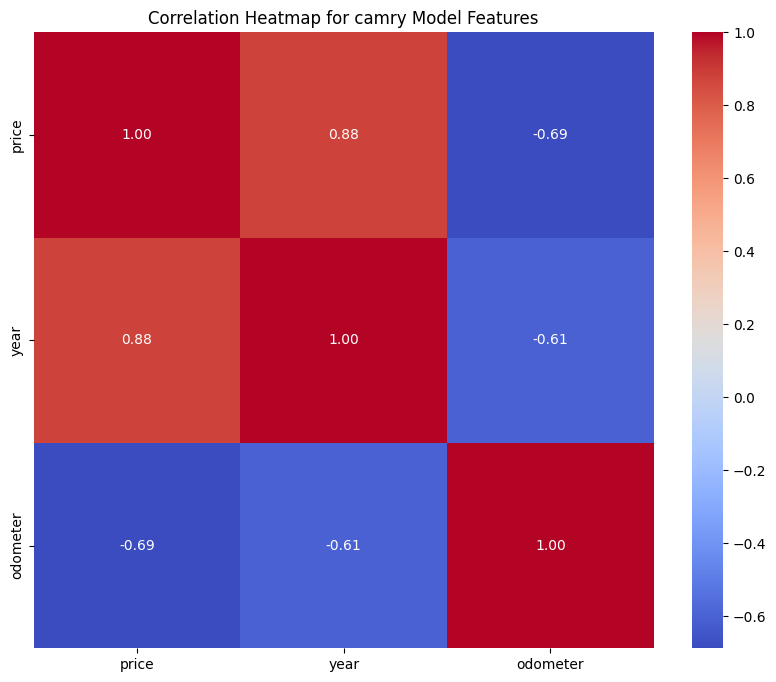

In [37]:
# Here, narrowing down the dataset to a specific model to see the correlation heatmap again with cleaned up data
# Find a car model (like Toyota Camry) with highest number of cars and put it in a separate dataframe and create a correlation heatmap for the new dataframe

# Find the model with the highest number of cars
model_counts = car_sales['model'].value_counts()
most_common_model = model_counts.index[0]

# Create a new dataframe for the most common model
df_most_common_model = car_sales[car_sales['model'] == most_common_model].copy()

print(f"\nDataframe for the model with the highest number of cars ({most_common_model}):")
print(df_most_common_model.head())
#print(df_most_common_model.corr())

# Select only the numerical columns for correlation analysis
numerical_cols = df_most_common_model.select_dtypes(include=np.number).columns
df_numerical = df_most_common_model[numerical_cols]

# Calculate the correlation matrix for the numerical columns of the new dataframe
correlation_matrix_most_common_model = df_numerical.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_most_common_model, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for {most_common_model} Model Features')
plt.show()

The heatmap now shows strong positive correlation between year and price. Also, it shows negative correlation between price and odometer. When we started, such correlation did not exist. The result is due to cleaup of data and also focus on specific model. Doing this accross all manufacturer and models creates a huge variance and it becomes difficult to draw conclusions. Unfortunately the dataset for specific models is really small and not enough to develop ML models for price predictions.  

In [38]:
# Count the number of vehicles sold based on column condition and generate the average price column

condition_counts = car_sales['condition'].value_counts().reset_index()
condition_counts.columns = ['condition', 'num_vehicles_sold']

avg_price_by_condition = car_sales.groupby('condition')['price'].mean().reset_index()
avg_price_by_condition.columns = ['condition', 'average_price']

condition_summary = pd.merge(condition_counts, avg_price_by_condition, on='condition')
print("\nNumber of vehicles sold and average price by condition:")
condition_summary.sort_values(by='average_price', ascending=False)


title_status_counts = car_sales['title_status'].value_counts().reset_index()
title_status_counts.columns = ['title_status', 'num_vehicles_sold']

avg_price_by_title_status = car_sales.groupby('title_status')['price'].mean().reset_index()
avg_price_by_title_status.columns = ['title_status', 'average_price']

title_status_summary = pd.merge(title_status_counts, avg_price_by_title_status, on='title_status')
print("\nNumber of vehicles sold and average price by title status:")
title_status_summary


transmission_counts = car_sales['transmission'].value_counts().reset_index()
transmission_counts.columns = ['transmission', 'num_vehicles_sold']

avg_price_by_transmission = car_sales.groupby('transmission')['price'].mean().reset_index()
avg_price_by_transmission.columns = ['transmission', 'average_price']

transmission_summary = pd.merge(transmission_counts, avg_price_by_transmission, on='transmission')
print("\nNumber of vehicles sold and average price by transmission:")
transmission_summary.sort_values(by='average_price', ascending=False)



Number of vehicles sold and average price by condition:

Number of vehicles sold and average price by title status:

Number of vehicles sold and average price by transmission:


,transmission,num_vehicles_sold,average_price
1,other,15160,24078.365897
0,automatic,112897,13667.419311
2,manual,5502,11915.946201


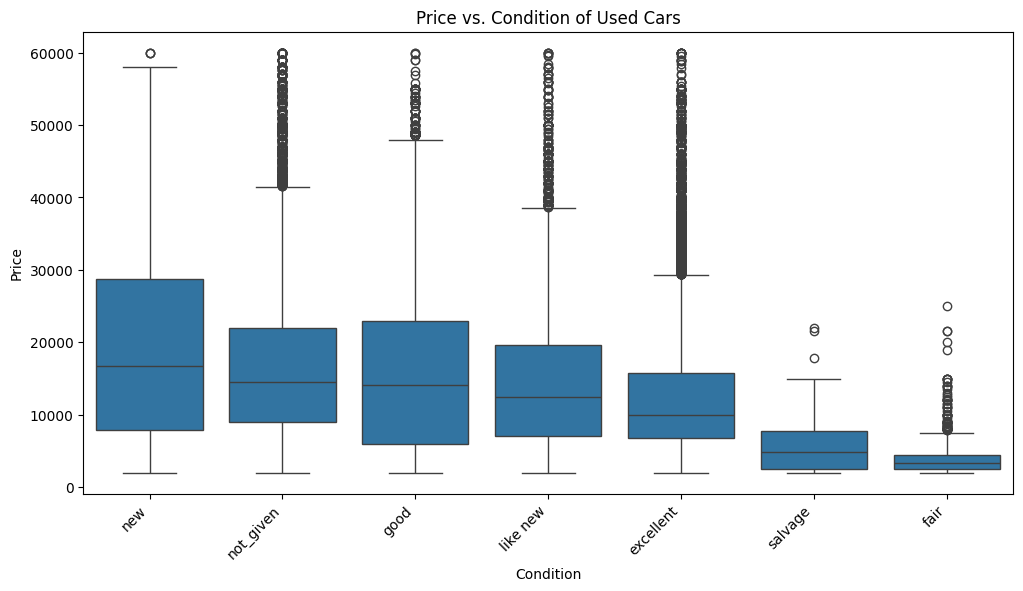

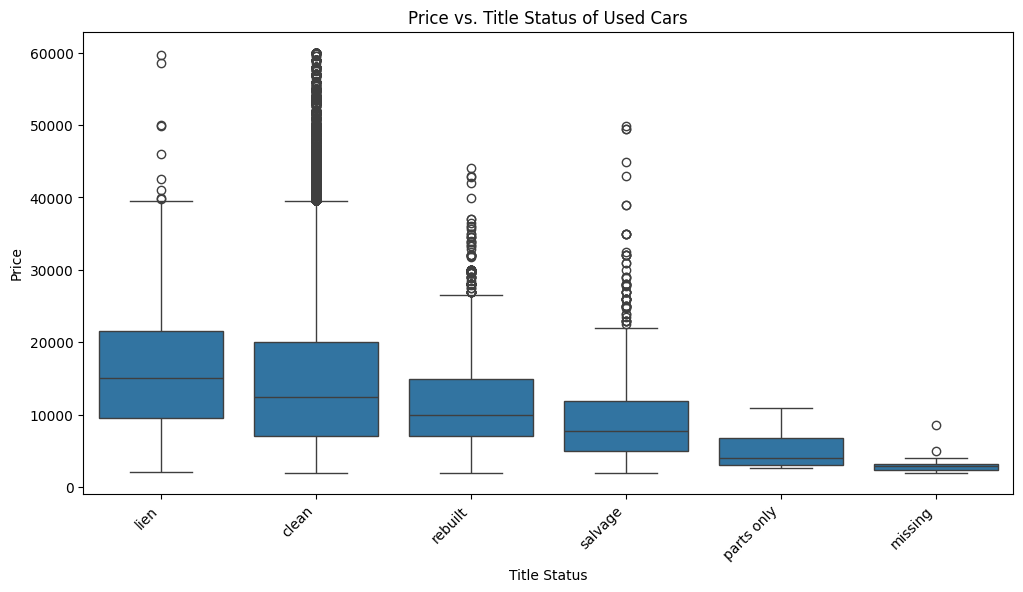

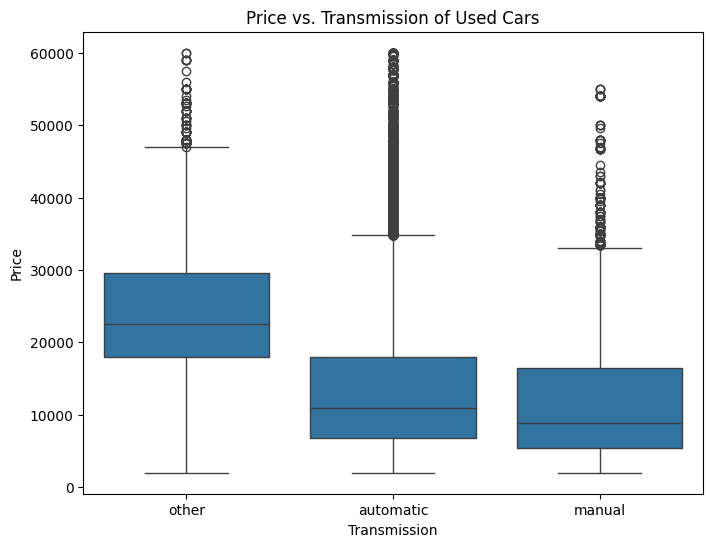

In [39]:
# Creating box plot for some of the features of used cars

# Box plot of 'condition' vs 'price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=car_sales, x='condition', y='price', order=condition_summary.sort_values(by='average_price', ascending=False)['condition'])
plt.title('Price vs. Condition of Used Cars')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Box plot of 'title_status' vs 'price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=car_sales, x='title_status', y='price', order=title_status_summary.sort_values(by='average_price', ascending=False)['title_status'])
plt.title('Price vs. Title Status of Used Cars')
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Box plot of 'transmission' vs 'price'
plt.figure(figsize=(8, 6))
sns.boxplot(data=car_sales, x='transmission', y='price', order=transmission_summary.sort_values(by='average_price', ascending=False)['transmission'])
plt.title('Price vs. Transmission of Used Cars')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.show()

This shows correlation of price with non-numeric values like condition, title_status and transmission. There is a lot of missing data in transmission feature so we cannot draw a conclusion with high degree of confidence

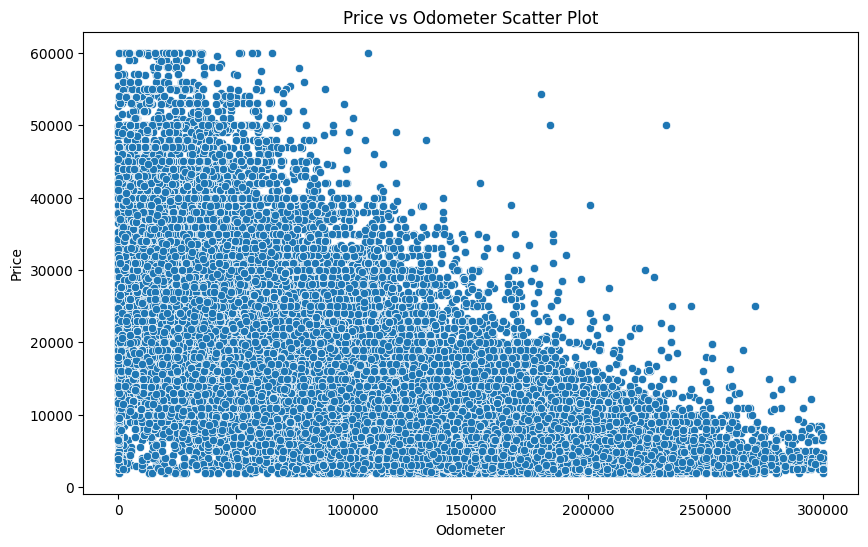

In [40]:
# Scatter plot for price and odometer

plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=car_sales)


plt.title('Price vs Odometer Scatter Plot')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.show()

This shows that as the odometer rating increases, the price decreases. However, there is a lot of variation due to other factors such condition, fuel type, title_status, manufacturer and model etc. That is why the price of a rarely used can range from $2,000 to $60,000. The ML model on this dataset can be diretionally correct but not very accurate Price vs Odometer

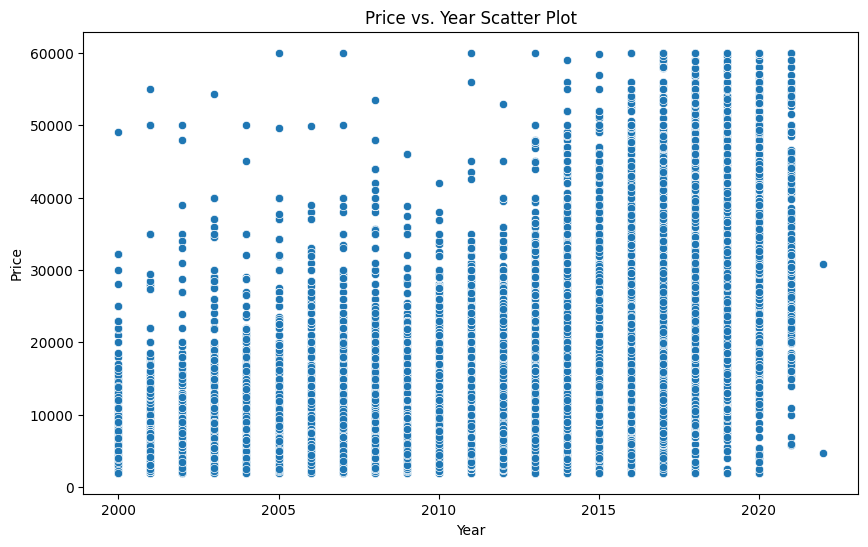

In [41]:
# Scatter plot for price and year

plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=car_sales)
plt.title('Price vs. Year Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

Shows the impact of manufacturing year on price. This shows that as the car gets old, the price decreases. Same as previous point, there is a lot of variation due to other factors such condition, fuel type, title_status, manufacturer and model etc. That is why the price of even a new car (manufactured after 2020) can range from $2,000 to $60,000. The model developed on this dataset can be diretionally correct but not very accurate

Count of Toyota Camry/Camery/Camry dataset: 2804


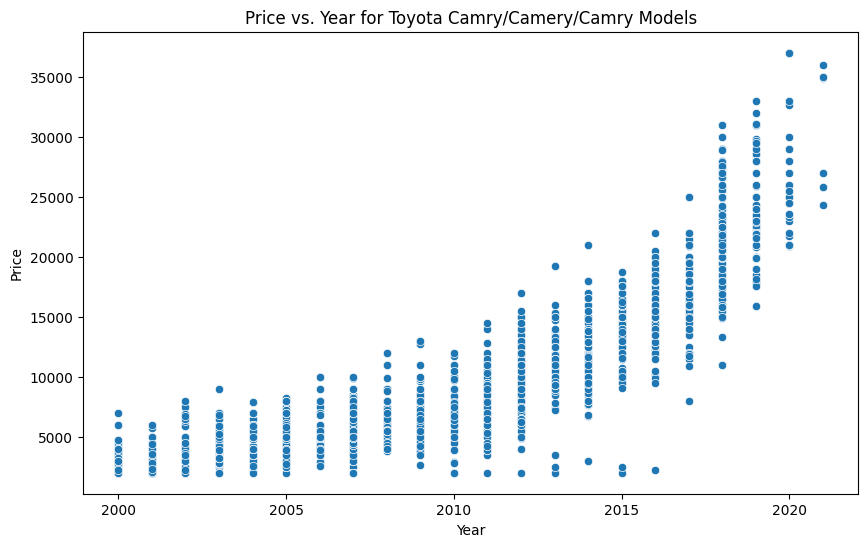

In [42]:
# Scatter plot for price and year where manufacturer is Toyota and model contains (camery, camary, camry).

import matplotlib.pyplot as plt
# Filter for Toyota and Camry/Camery/Camry models
toyota_camry_df = car_sales[
    (car_sales['manufacturer'] == 'toyota') &
    (car_sales['model'].str.contains('camry|camery|camry', case=False, na=False))
].copy()

# Print the count of this dataset
print(f"Count of Toyota Camry/Camery/Camry dataset: {len(toyota_camry_df)}")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=toyota_camry_df)
plt.title('Price vs. Year for Toyota Camry/Camery/Camry Models')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In this plot, the dataset is limited to only one model - Toyota Camry. This shows better linear relationship specially between 2008 to 2022. While there is some variance (visibly +/- 10k) in the price, this can be a better dataset to develop a model that predicts the price of the car per model (or models with similar price range). However, this dataset was not used in the model to predict price as there is not enough volume.

In [37]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133559 entries, 49 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        133559 non-null  object 
 1   price         133559 non-null  int64  
 2   year          133559 non-null  float64
 3   manufacturer  133559 non-null  object 
 4   model         133559 non-null  object 
 5   condition     133559 non-null  object 
 6   cylinders     133559 non-null  object 
 7   fuel          133559 non-null  object 
 8   odometer      133559 non-null  float64
 9   title_status  133559 non-null  object 
 10  transmission  133559 non-null  object 
 11  drive         133559 non-null  object 
 12  size          133559 non-null  object 
 13  type          133559 non-null  object 
 14  state         133559 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 16.3+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [38]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134260 entries, 49 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        134260 non-null  object 
 1   price         134260 non-null  int64  
 2   year          134260 non-null  float64
 3   manufacturer  134260 non-null  object 
 4   model         134260 non-null  object 
 5   condition     134260 non-null  object 
 6   cylinders     134260 non-null  object 
 7   fuel          134260 non-null  object 
 8   odometer      134260 non-null  float64
 9   title_status  134260 non-null  object 
 10  transmission  134260 non-null  object 
 11  drive         134260 non-null  object 
 12  size          134260 non-null  object 
 13  type          134260 non-null  object 
 14  state         134260 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 16.4+ MB


In [39]:
# Create different dataframes for building various models

car_sales_1 = car_sales[['price', 'odometer']].copy()
car_sales_2 = car_sales[['price', 'odometer', 'year']].copy()
car_sales_3 = car_sales[['price', 'odometer', 'year', 'title_status']].copy()


In [40]:
# First model, divide the data in car sales into train, test and dev

# Divide data into train, test, and dev sets
X = car_sales_1.drop('price', axis=1)
y = car_sales_1['price']

X = X - X.mean()
X = X / X.std()

y = y - y.mean()
y = y / y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Development set shape: {X_dev.shape}, {y_dev.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (80556, 1), (80556,)
Development set shape: (26852, 1), (26852,)
Test set shape: (26852, 1), (26852,)


Linear Regression Model Performance on Development Set (Predicting Price from Odometer):
Mean Squared Error (MSE): 0.79
Root Mean Squared Error (RMSE): 0.89


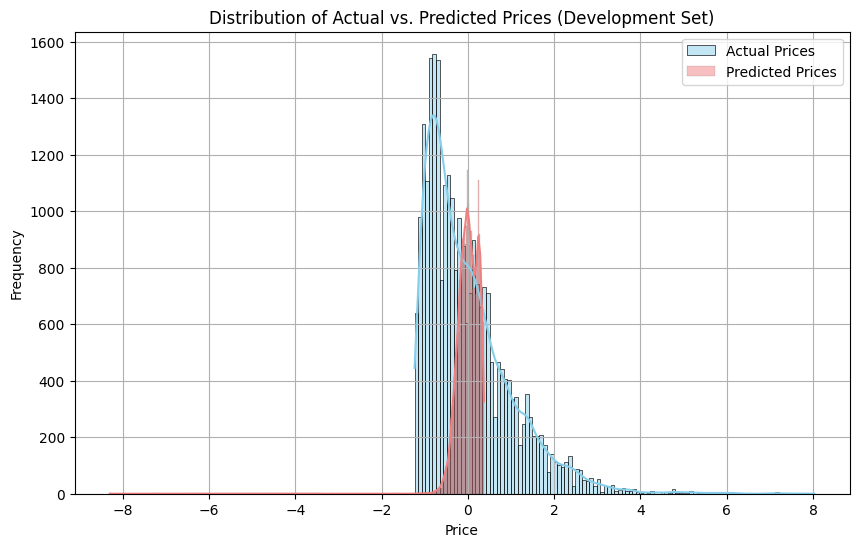

In [42]:
# First Model: Linear Regression model to predict the price from odometer

# Select features and target
features = ['odometer']
target = 'price'

X_train_odometer = X_train[features]
X_dev_odometer = X_dev[features]
X_test_odometer = X_test[features]

# Initialize and train the Linear Regression model
model_1 = LinearRegression()
model_1.fit(X_train_odometer, y_train)

# Evaluate the model on the development set
y_dev_pred = model_1.predict(X_dev_odometer)

mse = mean_squared_error(y_dev, y_dev_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Performance on Development Set (Predicting Price from Odometer):")

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs predicted values for model_1 on the development set
#plt.figure(figsize=(10, 6))
#plt.scatter(y_dev, y_dev_pred, alpha=0.5)
#plt.title('Model 1: Actual vs. Predicted Price (Development Set)')
#plt.xlabel('Actual Price')
#plt.ylabel('Predicted Price')
#plt.grid(True)
#plt.show()

# Plot histogram of predicted prices
plt.figure(figsize=(10, 6))
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)
sns.histplot(y_dev_pred, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Use model_1 to predict the price for odometer 50000

# The new odometer value
new_odometer_raw = 50000

# Calculate the mean and std of the original 'odometer' column in X
odometer_mean = car_sales['odometer'].mean()
odometer_std = car_sales['odometer'].std()

# Scale the new odometer value
new_odometer_scaled = (new_odometer_raw - odometer_mean) / odometer_std

# The model expects the input as a 2D array (number of samples, number of features)
# In this case, one sample and one feature ('odometer')
new_odometer_input = np.array([[new_odometer_scaled]])

# Predict the scaled price using the model
predicted_price_scaled = model_1.predict(new_odometer_input)

# The target 'y' (price) was also scaled:
# y = y - y.mean()
# y = y / y.std()
# We need the mean and std of the original 'price' column to unscale the prediction.

# Calculate the mean and std of the original 'price' column
price_mean = car_sales['price'].mean()
price_std = car_sales['price'].std()

# Unscale the predicted price
predicted_price_raw = (predicted_price_scaled * price_std) + price_mean

print(f"Predicted price for odometer {new_odometer_raw}: ${predicted_price_raw[0]:,.2f}")

Predicted price for odometer 50000: $16,835.46


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Multiple Linear Regression Model Evaluation (Numeric Features: Odometer, Year):
Mean Squared Error (MSE): 0.5436578456294423
Root Mean Squared Error (RMSE): 0.7373315710244899

Model Coefficients:
Intercept: -0.0018933920930490956
Odometer coefficient: -0.10874196710689729
Year coefficient: 0.6173318573803745


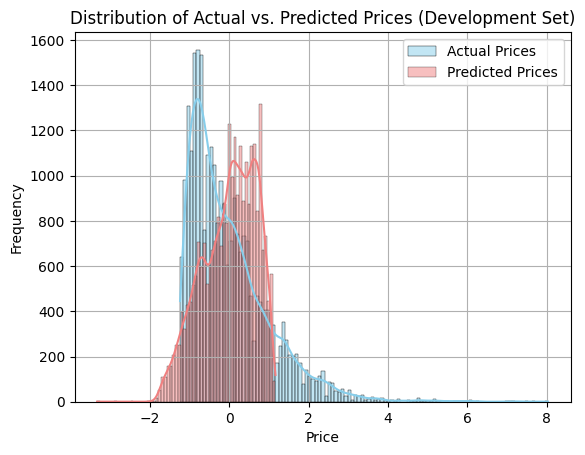

In [44]:
# Second Model: Multiple Linear Regression model to predict the price from numeric features odometer and years.

# Divide data into train, test, and dev sets
X = car_sales_2.drop('price', axis=1)
y = car_sales_2['price']

X = (X - X.mean()) / X.std()
y = (y - y.mean())/y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Select only 'odometer' and 'year' as features for this specific model
features = ['odometer', 'year']
X_train_numeric = X_train[features]
X_dev_numeric = X_dev[features]
X_test_numeric = X_test[features]

# Create and train the Linear Regression model
model_2 = LinearRegression(fit_intercept=True)
model_2.fit(X_train_numeric, y_train)

# Make predictions on the development set
y_pred_dev_numeric = model_2.predict(X_dev_numeric)

# Evaluate the model
mse_numeric = mean_squared_error(y_dev, y_pred_dev_numeric)
rmse_numeric = np.sqrt(mse_numeric)

print("Multiple Linear Regression Model Evaluation (Numeric Features: Odometer, Year):")
print(f"Mean Squared Error (MSE): {mse_numeric}")
print(f"Root Mean Squared Error (RMSE): {rmse_numeric}")

# Print model coefficients
print("\nModel Coefficients:")
print(f"Intercept: {model_2.intercept_}")
print(f"Odometer coefficient: {model_2.coef_[0]}")
print(f"Year coefficient: {model_2.coef_[1]}")

# Plot histogram of actual prices
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)

# Plot histogram of predicted prices
sns.histplot(y_pred_dev_numeric, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Use model_2 to predict the price for odometer and year

# Calculate the mean and standard deviation of 'odometer' and 'year' from the original car_sales
mean_odometer = car_sales_2['odometer'].mean()
std_odometer = car_sales_2['odometer'].std()
mean_year = car_sales_2['year'].mean()
std_year = car_sales_2['year'].std()

print(mean_odometer)
print(std_odometer)
print(mean_year)
print(std_year)

# Standardize the new data point

odometer = 5000
year = 2021
new_odometer_scaled = (odometer - mean_odometer) / std_odometer
new_year_scaled = (year - mean_year) / std_year

# Create a DataFrame for the new data point, ensuring column names match the training data
new_data = pd.DataFrame([[new_odometer_scaled, new_year_scaled]], columns=['odometer', 'year'])

# Use model_2 to predict the scaled price
predicted_price_scaled = model_2.predict(new_data)[0]

# We also need to unscale the predicted price.
# The target 'y' was standardized using (y - y.mean()) / y.std() from the original car_sales['price']
mean_price = car_sales_2['price'].mean()
std_price = car_sales_2['price'].std()

# Unscale the predicted price
predicted_price = (predicted_price_scaled * std_price) + mean_price

print(f"Predicted price is: ${predicted_price:.2f}")

97156.14802621778
95313.99247653225
2012.6701474750485
4.8617317060746
Predicted price is: $27098.99


In [46]:
car_sales_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134260 entries, 49 to 426878
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         134260 non-null  int64  
 1   odometer      134260 non-null  float64
 2   year          134260 non-null  float64
 3   title_status  134260 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 5.1+ MB


In [47]:
# Perform one hot encoding on car_sales_3 for column title_status

import pandas as pd
car_sales_3 = pd.get_dummies(car_sales_3, columns=['title_status'], drop_first=True)
car_sales_3.info()
car_sales_3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 134260 entries, 49 to 426878
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    134260 non-null  int64  
 1   odometer                 134260 non-null  float64
 2   year                     134260 non-null  float64
 3   title_status_lien        134260 non-null  bool   
 4   title_status_missing     134260 non-null  bool   
 5   title_status_parts only  134260 non-null  bool   
 6   title_status_rebuilt     134260 non-null  bool   
 7   title_status_salvage     134260 non-null  bool   
dtypes: bool(5), float64(2), int64(1)
memory usage: 4.7 MB


,price,odometer,year,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage
49,32990,20581.0,2020.0,False,False,False,False,False
59,14000,95000.0,2012.0,False,False,False,False,False
73,15000,90000.0,2017.0,False,False,False,True,False
75,18590,28942.0,2018.0,False,False,False,False,False
76,29590,70760.0,2017.0,False,False,False,False,False


In [48]:
# Divide data into train, test, and dev sets
X = car_sales_3.drop('price', axis=1)
y = car_sales_3['price']

X = (X - X.mean()) / X.std()
y = (y - y.mean())/y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Multiple Linear Regression Model Evaluation (Features: Odometer, Year, Title Status):
Mean Squared Error (MSE): 0.5352105196224695
Root Mean Squared Error (RMSE): 0.7315808360136763

Model Coefficients:
Intercept: -0.001566508198773358
Odometer coefficient: -0.11083103695755968
Year coefficient: 0.618768131768045
Title Status Coefficients:
title_status_lien: -0.004162522558366556
title_status_missing: -0.003387968851706811
title_status_parts only: -0.004009420656730514
title_status_rebuilt: -0.07914956379816122
title_status_salvage: -0.04990206046152706


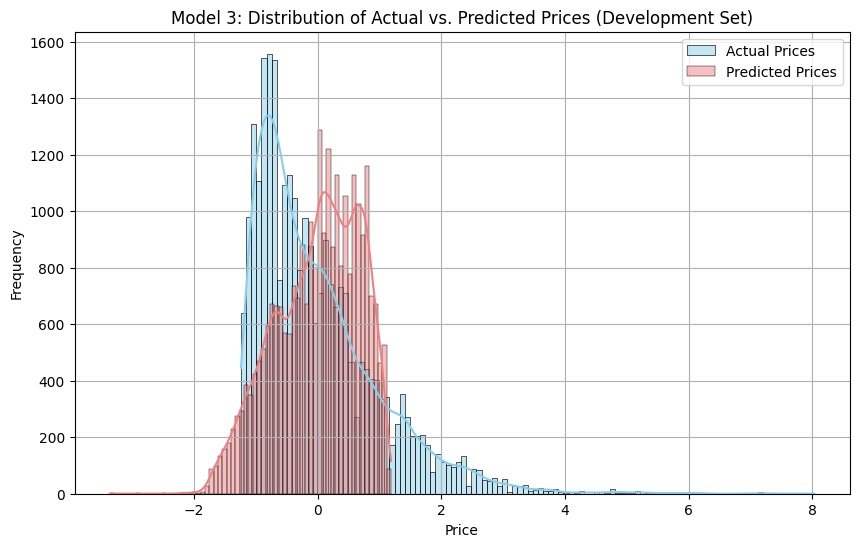

In [49]:
# Same as second model above, create a model_3 to predict price using dataset X which has odometer, year and title_status

# Select features and target
features = ['odometer', 'year'] + list(car_sales_3.columns[car_sales_3.columns.str.startswith('title_status_')])
target = 'price'

X_train_model3 = X_train[features]
X_dev_model3 = X_dev[features]
X_test_model3 = X_test[features]

# Create and train the Linear Regression model
model_3 = LinearRegression(fit_intercept=True)
model_3.fit(X_train_model3, y_train)

# Make predictions on the development set
y_pred_dev_model3 = model_3.predict(X_dev_model3)

# Evaluate the model
mse_model3 = mean_squared_error(y_dev, y_pred_dev_model3)
rmse_model3 = np.sqrt(mse_model3)

print("Multiple Linear Regression Model Evaluation (Features: Odometer, Year, Title Status):")
print(f"Mean Squared Error (MSE): {mse_model3}")
print(f"Root Mean Squared Error (RMSE): {rmse_model3}")

# Print model coefficients
print("\nModel Coefficients:")
print(f"Intercept: {model_3.intercept_}")
# Assuming the order of coefficients corresponds to the order of features
print(f"Odometer coefficient: {model_3.coef_[0]}")
print(f"Year coefficient: {model_3.coef_[1]}")
# Print coefficients for title status (adjust slicing based on the number of one-hot encoded columns)
title_status_cols = features[2:] # Features after odometer and year
print("Title Status Coefficients:")
for i, col in enumerate(title_status_cols):
    print(f"{col}: {model_3.coef_[2 + i]}")


# Plot histogram of actual vs predicted prices for model_3 on the development set
plt.figure(figsize=(10, 6))

# Plot histogram of actual prices
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)

# Plot histogram of predicted prices
sns.histplot(y_pred_dev_model3, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Model 3: Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Predict price of the car using model_3 with odometer, year , title_status

import pandas as pd
# Predict price using model_3 with the specified parameters

# Input parameters
odometer = 90000
year = 2007
title_status	= "salvage"
title_status_salvage = 1 # Or other possible values based on the one-hot encoded columns

# Use the mean and std from the original 'car_sales_3' dataframe before splitting and scaling
mean_odometer_m3 = car_sales_3['odometer'].mean()
std_odometer_m3 = car_sales_3['odometer'].std()
mean_year_m3 = car_sales_3['year'].mean()
std_year_m3 = car_sales_3['year'].std()

# Standardize the numeric features
new_odometer_scaled_m3 = (odometer - mean_odometer_m3) / std_odometer_m3
new_year_scaled_m3 = (year - mean_year_m3) / std_year_m3

# Create a dictionary for the new data point, including numeric and all possible one-hot encoded columns
# Initialize all one-hot encoded columns to 0, then set the correct one to 1
new_data_dict_m3 = {'odometer': new_odometer_scaled_m3, 'year': new_year_scaled_m3}

# Get the names of the one-hot encoded columns from the training data
one_hot_cols = [col for col in X_train_model3.columns if col.startswith('title_status_')]

# Initialize all one-hot encoded columns for the new data point to 0
for col in one_hot_cols:
    new_data_dict_m3[col] = 0

# Set the value for the specific title_status provided to 1
# Construct the column name that corresponds to the input title_status
title_status_col_name = f'title_status_{title_status}'

# Check if the specified title_status exists in the one-hot encoded columns
if title_status_col_name in one_hot_cols:
    new_data_dict_m3[title_status_col_name] = 1
else:
    print(f"Warning: '{title_status}' is not a recognized title_status from the training data.")
    # Handle cases where the input title_status is not seen in training (e.g., default to a common one or handle as unknown)
    # For now, we will proceed with the existing columns, effectively treating the unknown status as if none of the trained statuses apply.
    # This might require more sophisticated handling in a production scenario.

# Create a DataFrame from the dictionary, ensuring the column order matches the training data
new_data_m3 = pd.DataFrame([new_data_dict_m3])[X_train_model3.columns]

# Use model_3 to predict the scaled price
predicted_price_scaled_m3 = model_3.predict(new_data_m3)[0]

# Unscale the predicted price
# Use the mean and std of the original 'price' from car_sales_3
mean_price_m3 = car_sales_3['price'].mean()
std_price_m3 = car_sales_3['price'].std()

predicted_price_raw_m3 = (predicted_price_scaled_m3 * std_price_m3) + mean_price_m3

print(f"Predicted price for a car with Odometer {odometer}, Year {year}, and Title Status '{title_status}': ${predicted_price_raw_m3:.2f}")


Predicted price for a car with Odometer 90000, Year 2007, and Title Status 'salvage': $6943.51


LASSO Regression Model (alpha=0.1) Evaluation on Development Set:
Mean Squared Error (MSE): 0.5643224322814236
Root Mean Squared Error (RMSE): 0.7512139723683418

Model Coefficients:
Intercept: -0.0015872403096028821
Odometer coefficient: -0.047356964916773096
Year coefficient: 0.5449227951017322


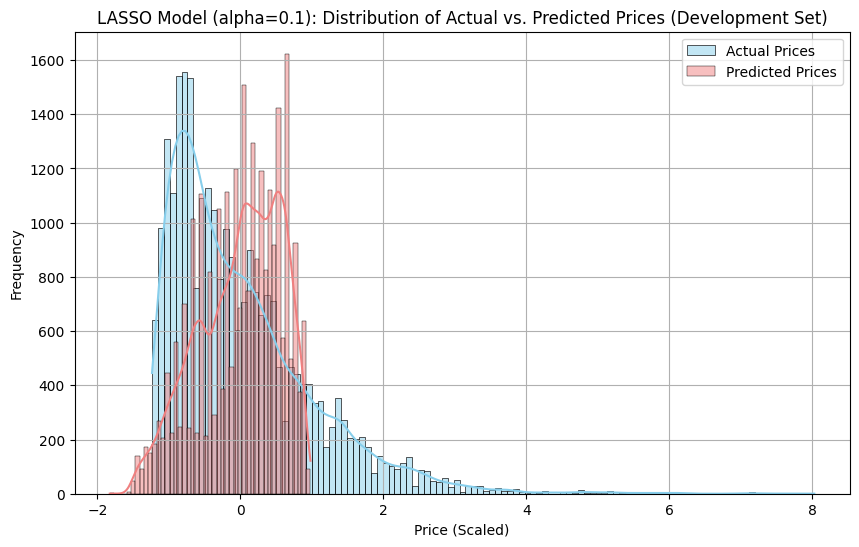

In [53]:
# Use LASSO regression model to predict price from odometer and years

# Import Lasso from sklearn.linear_model
from sklearn.linear_model import Lasso

# Define features and target
features = ['odometer', 'year']
target = 'price'

# Prepare data for LASSO - using car_sales_2 which only has 'price', 'odometer', 'year'
X = car_sales_2.drop(target, axis=1)
y = car_sales_2[target]

# Standardize features and target
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Split data into training, development, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize and train the LASSO regression model
# We'll use a range of alpha values and evaluate using cross-validation later if needed,
# but for a basic model as requested, we'll start with one alpha.
# A common starting point for alpha is 1.0, but you can tune this.
alpha = 0.1  # Regularization strength

model_lasso = Lasso(alpha=alpha, random_state=42)
model_lasso.fit(X_train[features], y_train)

# Evaluate the model on the development set
y_pred_dev_lasso = model_lasso.predict(X_dev[features])

mse_lasso = mean_squared_error(y_dev, y_pred_dev_lasso)
rmse_lasso = np.sqrt(mse_lasso)

print(f"LASSO Regression Model (alpha={alpha}) Evaluation on Development Set:")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")

# Print model coefficients
print("\nModel Coefficients:")
print(f"Intercept: {model_lasso.intercept_}")
# Assuming the order of coefficients corresponds to the order of features ['odometer', 'year']
print(f"Odometer coefficient: {model_lasso.coef_[0]}")
print(f"Year coefficient: {model_lasso.coef_[1]}")

# Plot histogram of actual vs predicted prices for the LASSO model on the development set
plt.figure(figsize=(10, 6))

# Plot histogram of actual prices
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)

# Plot histogram of predicted prices
sns.histplot(y_pred_dev_lasso, color='lightcoral', label='Predicted Prices', kde=True)

plt.title(f'LASSO Model (alpha={alpha}): Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price (Scaled)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.